# A Deep Dive into the S&P 500: Predicting Stock Prices
Kanishk Chinnapapannagari, Aarav Naveen, Avyay Potarlanka, and Melvin Rajendran

## Introduction

In today’s evolving financial landscape, both investors and traders are constantly seeking an edge to make informed decisions. The stock market, which contains an intricate web of variables and is influenced by numerous factors, has proven to be a difficult environment to navigate.

In the past, investment-related decisions were often made based on analysis of historical trends. However, the advancement of data science and machine learning techniques has introduced a new opportunity to potentially predict future stock prices with reasonable accuracy and thus gain valuable insights.

This data science project delves into prediction of stock prices within the Standard & Poor’s 500 index, otherwise known as the S&P 500. This index contains 500 of the top companies in the United States, and it represents approximately 80% of the U.S. stock market’s total value. Hence, it serves as a strong indicator of the movement within the market. To learn more about the S&P 500 and other popular indices in the U.S., read this article: https://www.investopedia.com/insights/introduction-to-stock-market-indices/.

Throughout this project, we will follow a comprehensive data science approach that includes the following steps:
* Data collection
* Data processing
* Exploratory data analysis and data visualization
* Data analysis, hypothesis testing, and machine learning (ML)
* Insight formation

Our project aims to leverage predictive modeling techniques to provide insights to investors. The analysis herein will identify stocks that are undervalued and thus will increase in price in the near future, meaning investors should consider buying or holding shares. Likewise, it will also identify stocks that are overvalued and will soon decrease in price, indicating that investors should consider selling their position.

In [167]:
# Import necessary libraries
from bs4 import BeautifulSoup
import numpy as np
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Data Collection

### Reading in a Kaggle Dataset

To gather information about the S&P 500 companies, we will be using the following dataset: https://www.kaggle.com/datasets/paultimothymooney/stock-market-data. This Kaggle dataset contains the date, volume, and prices for the NASDAQ, NYSE, and S&P 500. For the purposes of this project, we will only analyze the stock prices of companies in the S&P 500.

In [153]:
# Initialize an empty data frame to store the stock price data
price_data = pd.DataFrame()

# Initialize the path to the folder containing the data
folder_path = 'sp500-data'

# Iterate across each file in the folder by name
for file_name in os.listdir(folder_path):
    
    # Check if the current file is a CSV file
    if file_name.endswith('.csv'):
        
        # Read the current file into a temporary data frame
        temp = pd.read_csv(os.path.join(folder_path, file_name))
        
        # Extract the symbol from the current file's name
        symbol = file_name[0:-4]
        
        # Store the symbol in a new column in the temporary data frame 
        temp['Symbol'] = symbol
        
        # Concatenate the accumulating and temporary data frames
        price_data = pd.concat([price_data, temp], ignore_index = True)

# Print the first five rows of the price data frame
price_data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Symbol
0,16-02-1990,0.073785,0.0,940636800.0,0.079861,0.077257,0.054862,CSCO
1,20-02-1990,0.074653,0.0,151862400.0,0.079861,0.079861,0.056712,CSCO
2,21-02-1990,0.075521,0.0,70531200.0,0.078993,0.078125,0.055479,CSCO
3,22-02-1990,0.078993,0.0,45216000.0,0.081597,0.078993,0.056095,CSCO
4,23-02-1990,0.078125,0.0,44697600.0,0.079861,0.078559,0.055787,CSCO


### Webscraping From Wikipedia

We noticed that the Kaggle dataset does not contain sector data. For this reason, we will supplement our existing data with that which is contained on the following webpage: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies. By scraping this webpage's list of the S&P 500 companies, we can match each company in our existing data to its corresponding GICS sector and sub-industry. This will enable us to perform analysis by sector and/or sub-industry and thus eliminate biases in our modeling.

In [154]:
# Headers for the HTTP request
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'From': 'pleaseletmein@gmail.com'
}

# Make an HTTP request to the Wikipedia URL and store the response
response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', headers = headers)

# Parse the text from the webpage as HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table element containing the data and both extract and store the data
table = soup.find('table')

# Read the HTML table into a data frame
sector_data = pd.read_html(str(table), flavor = 'html5lib')[0]

# Print the first five rows of the sector data frame
sector_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


### Webscraping From Slickcharts

We would also like to focus our attention on the top 10 companies of each sector, as these companies drive the movement within their respective sectors. Hence, we will scrape the data from the following webpage: https://www.slickcharts.com/sp500. This webpage contains a list of the S&P 500 companies by weight, where weight is equal to a company's market cap divided by the overall value of the S&P 500. Ultimately, we will select the top 10 companies of each sector by weight.

In [155]:
# Make an HTTP request to the Slickcharts URL and store the response
response = requests.get('https://www.slickcharts.com/sp500', headers = headers)

# Parse the text from the webpage as HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table element containing the data and both extract and store the data
table = soup.find('table')

# Read the HTML table into a data frame
weight_data = pd.read_html(str(table), flavor = 'html5lib')[0]

# Print the first five rows of the sector data frame
weight_data.head()

,#,Company,Symbol,Weight,Price,Chg,% Chg
0,1,Apple Inc.,AAPL,7.460914,173.78,0.23,(0.13%)
1,2,Microsoft Corporation,MSFT,6.719669,310.14,-2.18,(-0.70%)
2,3,Amazon.com Inc.,AMZN,2.839973,112.14,1.95,(1.77%)
3,4,NVIDIA Corporation,NVDA,2.054238,286.26,-2.60,(-0.90%)
4,5,Alphabet Inc. Class A,GOOGL,1.924191,116.68,4.93,(4.41%)


## Data Processing

We will merge the data collected in the previous step into a single data frame. Then, we will filter our data to include only the top 5 companies within each sector. As part of this process, we need to caste our data to the proper types, remove entries with missing values, and remove unnecessary columns.

### Cleaning the Sector Data

In [156]:
# Rename the sector and industry-related columns
sector_data = sector_data.rename(columns = {'GICS Sector': 'Sector', 'GICS Sub-Industry': 'Industry'})

# Drop unnecessary columns
sector_data = sector_data.drop(['Headquarters Location', 'Date added', 'CIK', 'Founded'], axis = 1)

# Print the first five rows of the data frame
sector_data.head()

,Symbol,Security,Sector,Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Pharmaceuticals
4,ACN,Accenture,Information Technology,IT Consulting & Other Services


### Cleaning the Weight Data

In [157]:
# Drop all columns except Symbol and Weight
weight_data = weight_data.drop(['#', 'Company', 'Price', 'Chg', '% Chg'], axis = 1)

# Print the first five rows of the data frame
weight_data.head()

,Symbol,Weight
0,AAPL,7.460914
1,MSFT,6.719669
2,AMZN,2.839973
3,NVDA,2.054238
4,GOOGL,1.924191


### Merging the Three Data Frames

In [158]:
# Perform an inner join (merge) on all three data frames to create a single data frame
data = pd.merge(pd.merge(price_data, sector_data, on = 'Symbol'), weight_data, on = 'Symbol')

# Reindex the columns of the data frame
data = data.reindex(columns = ['Symbol', 'Security', 'Sector', 'Industry', 'Weight', 'Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close'])

# Cast the Date column's type to datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst = True)

# Print the first five rows of the resulting data frame
data.head()

,Symbol,Security,Sector,Industry,Weight,Date,Open,High,Low,Close,Adjusted Close
0,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-16,0.0,0.079861,0.073785,0.077257,0.054862
1,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-20,0.0,0.079861,0.074653,0.079861,0.056712
2,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-21,0.0,0.078993,0.075521,0.078125,0.055479
3,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-22,0.0,0.081597,0.078993,0.078993,0.056095
4,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-23,0.0,0.079861,0.078125,0.078559,0.055787


### Filtering the Top 5 Companies Within Each Sector

In [164]:
# Initialize an empty data frame to contain the filtered data
top_data = pd.DataFrame()

# Iterate across a list of the unique sectors
for sector in data['Sector'].unique():
    
    # Filter the data by the current sector
    sector_data = data[data['Sector'] == sector]

    # Compile a list of the top five weights in the current sector
    top_five_weights = sorted(sector_data['Weight'].unique(), reverse = True)[:5]
    
    # Filter the data by the top five weights
    sector_data = sector_data[sector_data['Weight'].isin(top_five_weights)]
    
    # Concatenate the top five companies' data into the accumulating dataframe
    top_data = pd.concat([top_data, sector_data], ignore_index = True)

# Print the first five rows of the filtered data frame
top_data.head()

,Symbol,Security,Sector,Industry,Weight,Date,Open,High,Low,Close,Adjusted Close
0,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-16,0.0,0.079861,0.073785,0.077257,0.054862
1,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-20,0.0,0.079861,0.074653,0.079861,0.056712
2,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-21,0.0,0.078993,0.075521,0.078125,0.055479
3,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-22,0.0,0.081597,0.078993,0.078993,0.056095
4,CSCO,Cisco,Information Technology,Communications Equipment,0.554749,1990-02-23,0.0,0.079861,0.078125,0.078559,0.055787


## Exploratory Data Analysis and Data Visualization

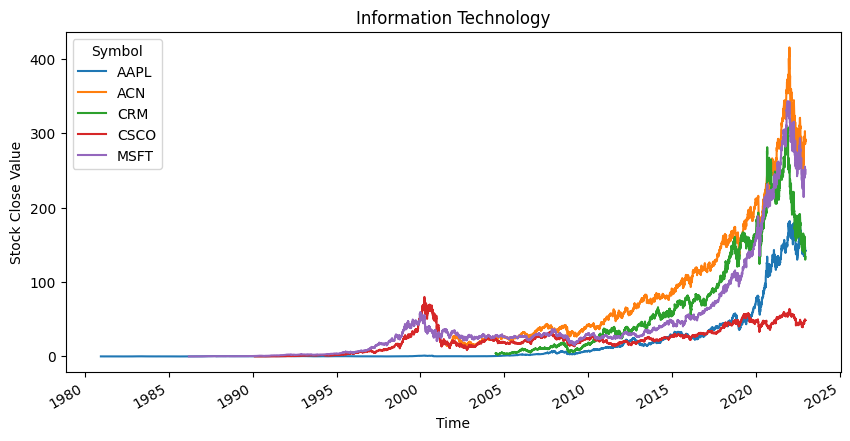

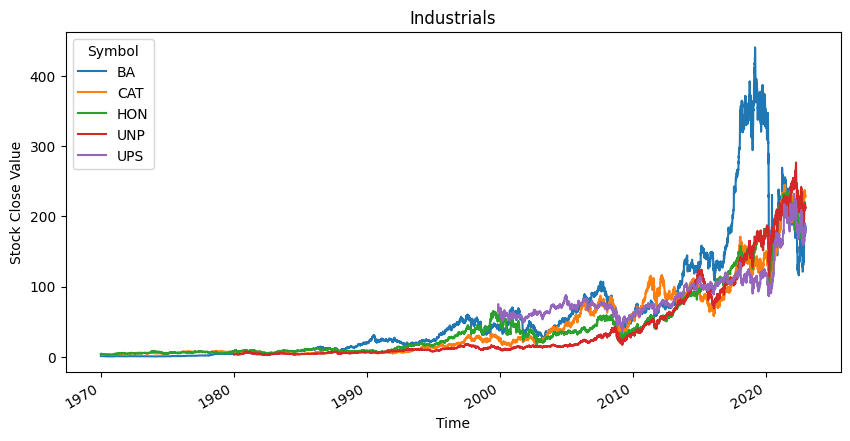

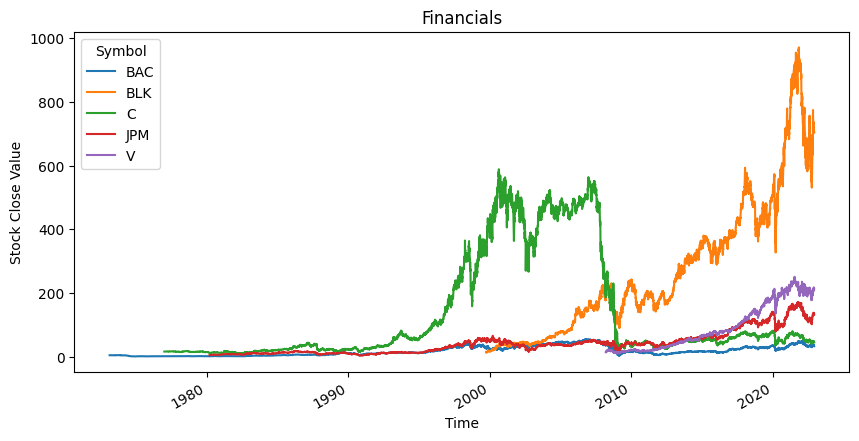

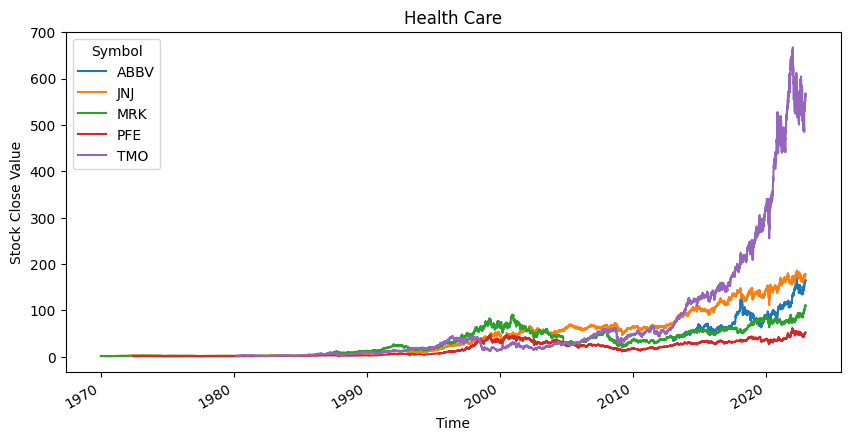

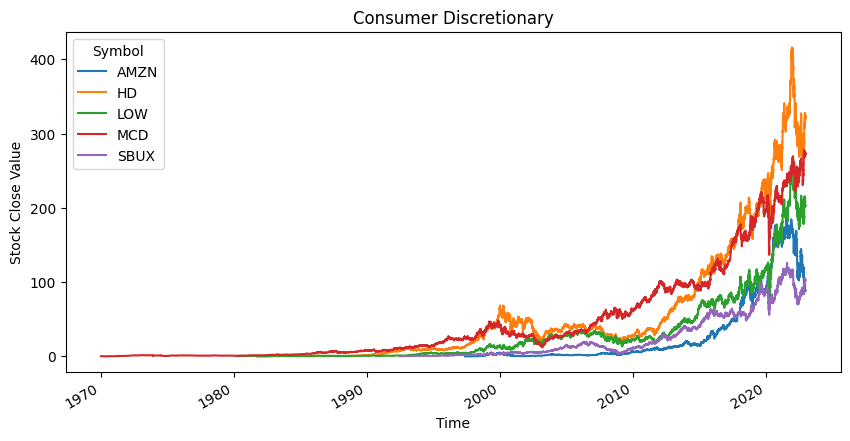

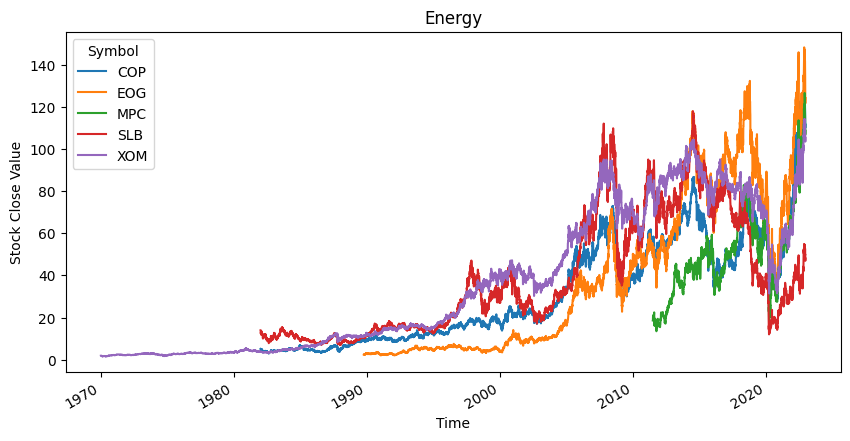

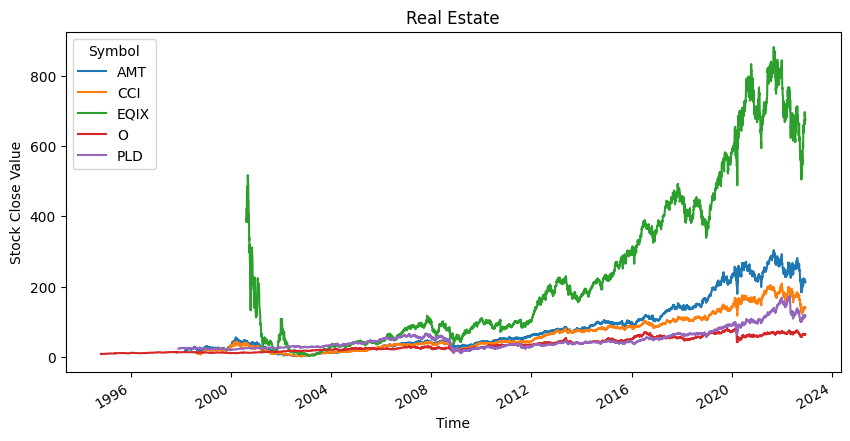

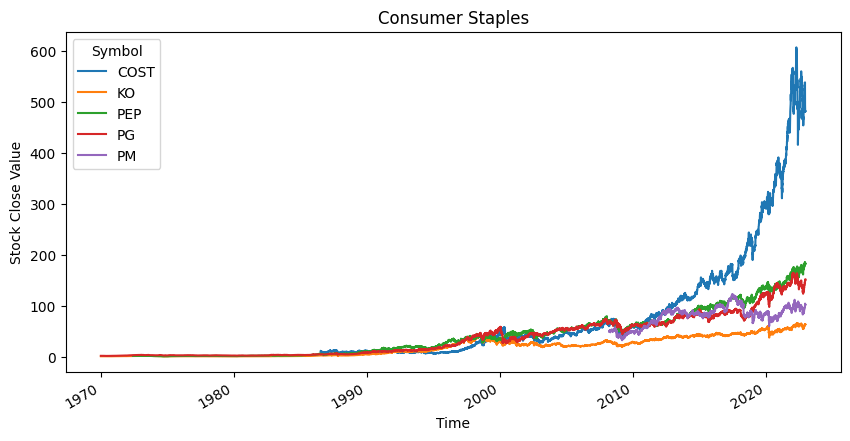

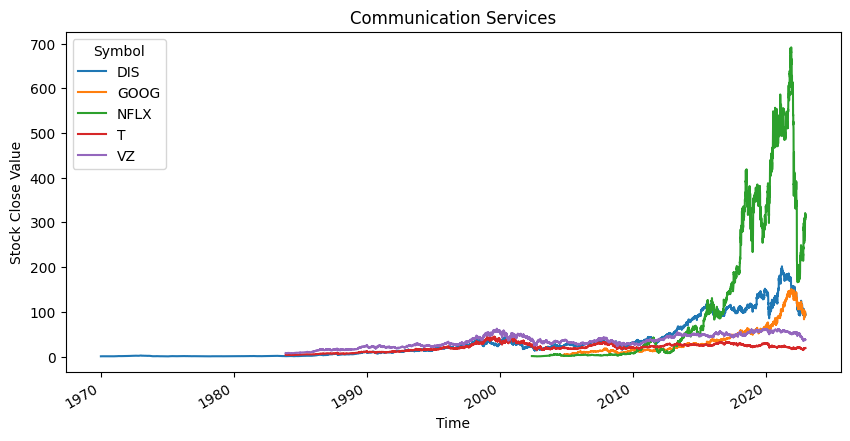

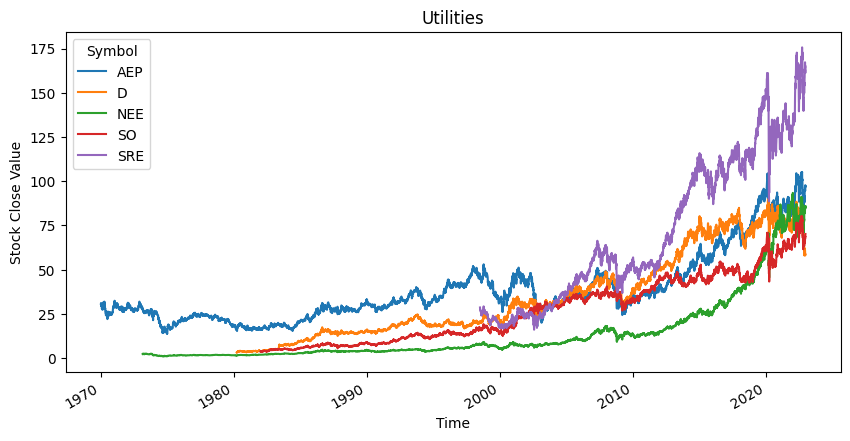

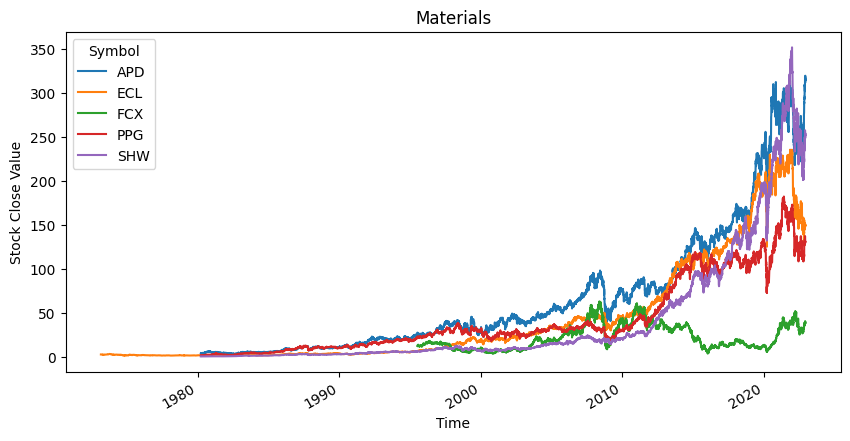

In [186]:
# Generate plot for each sector
for sector in top_data['Sector'].unique():
    # Get data for this sector
    sector_data = top_data[top_data['Sector'] == sector]
    # Reshape data for plotting purpose
    sec_as_row = sector_data.pivot(index='Date', columns='Symbol', values='Close')
    # Generate plot
    sec_as_row.plot(title=sector, legend=True, xlabel="Time", ylabel="Stock Close Value", figsize=(10,5))
        

## Data Analysis, Hypothesis Testing, and Machine Learning

## Insights